In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def velocity_right_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[0, :] + counts[2, :]) / 2 * 0.0022) / delta_t

def velocity_left_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[1, :] + counts[3, :]) / 2 * 0.0022) / delta_t

def sync_time_stamps(t1, t2):
    t1_synced = []
    ind = 0
    for i in range(len(t1)):
        while(t2[ind] < t1[i] and ind < len(t2) - 1):
            ind += 1
        t1_synced.append(ind)
    return np.array(t1_synced)

In [4]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    print(data)
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

NpzFile '../data/Encoders20.npz' with keys: counts, time_stamps


In [5]:
with np.load("../data/Imu%d.npz"%dataset) as data:
    print(data)
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

NpzFile '../data/Imu20.npz' with keys: angular_velocity, linear_acceleration, time_stamps


In [6]:
synced_encoder_stamps = sync_time_stamps(imu_stamps, encoder_stamps)

v_left = velocity_left_encoder(encoder_counts, encoder_stamps)
v_right = velocity_right_encoder(encoder_counts, encoder_stamps)

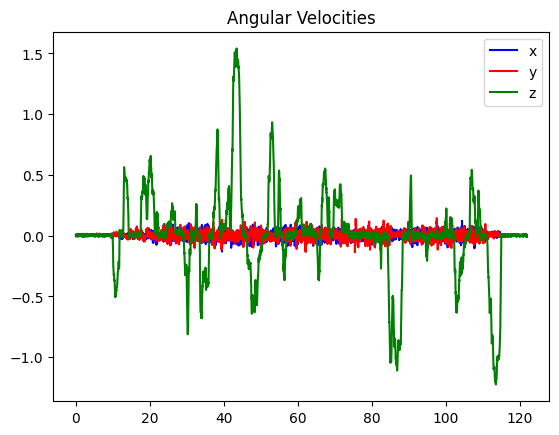

In [7]:
# Plotting the x, y, z velocities
plt.title("Angular Velocities")
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[0], color='blue')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[1], color='red')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[2], color='green')
plt.legend(['x', 'y', 'z'])
plt.show()

0.0 0.0 12 0.004904669727341521
0.0 0.0 12 0.002089555337445731
0.0 0.0 12 -0.0003033670622295286
0.0 0.0 13 -0.0014082590674882214
0.0 0.0 13 -0.0017467799204055276
0.0 0.0 14 0.0005168656194432681
0.0 0.0 14 0.004455802894190218
0.0 0.0 14 0.005942876495919448
0.0 0.0 15 0.005680187339739342
0.0 0.0 15 0.005539333536629851
0.0 0.0 16 0.00545381294174804
0.0 0.0 16 0.005383248207354552
0.0 0.0 16 0.005294323185187767
0.0 0.0 17 0.005145053174985701
0.0 0.0 17 0.00486496243792626
0.0 0.0 17 0.004321810066384209
0.0 0.0 18 0.00325915429670873
0.0 0.0 18 0.00117527713225023
0.0 0.0 19 -0.0009180716555305948
0.0 0.0 19 -0.002013614189096771
0.0 0.0 20 -0.0026285954887753024
0.0 0.0 20 -0.0030533703377973852
0.0 0.0 20 -0.0034884902151668
0.0 0.0 21 -0.00413939085972377
0.0 0.0 21 -0.005313385868896028
0.0 0.0 22 -0.005569137390901166
0.0 0.0 22 -0.003031771808218995
0.0 0.0 22 0.0015010692951102187
0.0 0.0 23 0.006178256969059655
0.0 0.0 23 0.009216813469574502
0.0 0.0 24 0.01005572746524

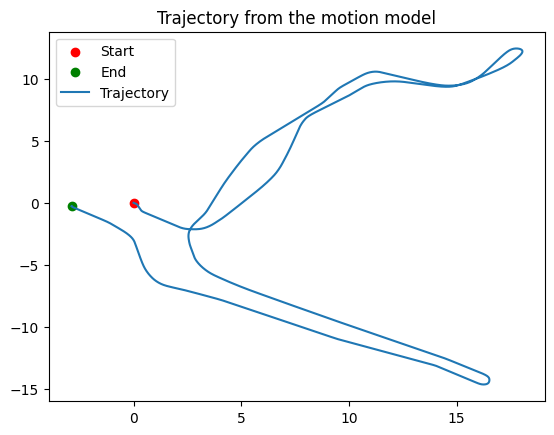

In [12]:
# Motion model
axel_length = 0.31115 # meters
wheel_diameter = 0.254 # meters

def motion_model(pose, v, omega, dt):
    x, y, theta = pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])

pose = np.zeros((3))

x_traj = [0]
y_traj = [0]

for i in range(len(imu_angular_velocity[2])):
    omega = imu_angular_velocity[2][i] # yaw angular velocity
    dt = imu_stamps[i] - imu_stamps[i - 1]
    encoder_ind = synced_encoder_stamps[i]
    v = (v_left[encoder_ind] + v_right[encoder_ind]) / 2
    pose = motion_model(pose, v, omega, dt)

    x_traj.append(pose[0])
    y_traj.append(pose[1])
    print(pose[0], pose[1], encoder_ind, omega)

# Beginning point
plt.scatter(0, 0, c='r')
# Ending point
plt.scatter(pose[0], pose[1], c='g')
plt.title("Trajectory from the motion model")
plt.plot(x_traj, y_traj)
plt.legend(["Start", "End", "Trajectory"])
plt.show()